In [8]:
import os

import matplotlib
matplotlib.rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
from matplotlib import gridspec
import pandas as pd
import seaborn as sns


import numpy as np
import torch
from sklearn.decomposition import NMF
import glob
import itertools

import warnings
warnings.filterwarnings("ignore")

from functions import cosine_HA
from AAUtoSig_init import AAUtoSig, train_AAUtoSig
from optuna_opt import optuna_tune, optuna_NMF

from joblib import Parallel, delayed
from datetime import date

In [12]:
%%capture --no-stderr
def split_data(data, frac_1):
  x_train = data.sample(frac = frac_1)
  x_validation = data.drop(x_train.index)
  return x_train, x_validation
  

def compare_NMF_AE(train_df, validation_df, epochs):
   n_pat = train_df.shape[0]
   #define models
   nsigs_NMF = optuna_NMF(X = train_df, epochs  = epochs)

   relu_activation = [False, False]
   loss_AE = torch.nn.MSELoss()
   params_AE = optuna_tune(X = train_df, criterion = loss_AE, epochs = epochs, relu_activation = relu_activation)
   nsigs_AE = params_AE['nsig']
   print(nsigs_NMF)
   print(nsigs_AE)
   if nsigs_AE != nsigs_NMF:
      nsigs = int(np.median(range(min(nsigs_AE, nsigs_NMF), max(nsigs_AE, nsigs_NMF) + 1)))
      print(nsigs)
   if nsigs_AE == nsigs_NMF:
      nsigs = nsigs_AE


   model_NMF = NMF(n_components = nsigs, init = 'random', max_iter = epochs, solver = 'mu')
   
   model_AE = AAUtoSig(96, nsigs, relu_activation=relu_activation)
   
   optimizer_AE = torch.optim.Adam(model_AE.parameters(), lr = params_AE['lr'])
   
   # fit and extract factor matrices
   train_AAUtoSig(epochs, model_AE, train_df, validation_df, criterion = loss_AE, optimizer=optimizer_AE, batch_size = params_AE['batch_size'], do_plot=False)

   exposures_NMF = model_NMF.fit_transform(train_df)
   signatures_NMF = model_NMF.components_

   signatures_AE = model_AE.dec1.weight.data   

   signatures_AE = pd.DataFrame(signatures_AE.numpy())
   exposures_AE = model_AE.enc1.weight.data@train_df.T

   
   # calculate out-of-sample error
   ref_exposures_NMF = model_NMF.transform(X = validation_df)
   rec_NMF = np.dot(ref_exposures_NMF, signatures_NMF)
   out_error_NMF = np.mean(((validation_df - rec_NMF)**2).to_numpy()) 
    
   validation_tensor = torch.tensor(validation_df.values,
                                    dtype = torch.float32)
   rec_data = model_AE(validation_tensor)
   out_error_AE = loss_AE(validation_tensor, rec_data).detach().item()

   # cosine distance between NMF and AE sigs
   cos = cosine_HA(signatures_NMF, signatures_AE.T)[0]
   cos_mean = np.mean(cos.diagonal())

   #scale exposures so signatures sum to one
   diagonals_NMF = signatures_NMF.sum(axis = 1)
   scale_NMF = np.diag(diagonals_NMF)

   diagonals_AE = signatures_AE.sum(axis = 0)
   scale_AE = np.diag(diagonals_AE)


   exposures_NMF = exposures_NMF@scale_NMF
   
   exposures_AE = exposures_AE.T@scale_AE

   # exposure difference
   exp_diff = np.mean(((exposures_NMF - exposures_AE)**2).to_numpy())

   #out_error_difference
   #our_err_diff = out_error_NMF - out_error_AE
   return [cos_mean, exp_diff, out_error_NMF, out_error_AE]

def performance_analysis(df_name, dict1, dict2, epochs):
   print(df_name)
   n_cancers = "1"
   if len(df_name) > 8:
      n_cancers = "2"
   if df_name == "all":
      n_cancers = "5"
   m1 = dict1[df_name]
   m2 = dict2[df_name]
   n1 = m1.shape[1]
   n2 = m2.shape[1]
   
   train_data1, test_data1 = split_data(m1.T, 0.8)
   train_data2, test_data2 = split_data(m2.T, 0.8)

   train_data1 = train_data1/train_data1.max().max()
   train_data2 = train_data2/train_data2.max().max()

   test_data1 = test_data1/train_data1.max().max()
   test_data2 = test_data2/train_data2.max().max()

   train_pool = pd.concat([train_data1, train_data2], axis = 0)
   test_pool = pd.concat([test_data1, test_data2], axis = 0)

   n_pool = n1 + n2

   res1 = compare_NMF_AE(train_data1, test_data1, epochs)
   res2 = compare_NMF_AE(train_data1, test_data1, epochs)
   res_pool = compare_NMF_AE(train_pool, test_pool, epochs)

   res1 = [n1, df_name, n_cancers, "PCAWG"] + res1
   res2 = [n2, df_name, n_cancers, "GEL"] + res2
   res_pool = [n_pool, df_name, n_cancers, "Both"] + res_pool

   res = pd.DataFrame([res1, res2, res_pool], columns = ["n_pat", "diagnosis", "n_cancers", "source", "cosine", "exp", "out_error_NMF", "out_error_AE"])
   return(res)

## Load data
We'll load 10 datasets.
5 single cancers from PCAWG: Prostate, Breast, Ovary, Pancreas, Lung 
and the same 5 cancers from GEL.

In [3]:
PCAWG = pd.read_csv(r'Q:\AUH-HAEM-FORSK-MutSigDLBCL222\external_data\Alexandrov_2020_synapse\WGS_PCAWG_2018_02_09\WGS_PCAWG.96.csv')
PCAWG.index = [t[0] + '[' + m + ']' + t[2] for (t,m) in zip(PCAWG['Trinucleotide'], PCAWG['Mutation type'])]
PCAWG = PCAWG.drop(['Trinucleotide', 'Mutation type'], axis = 1)

search_sets = [{'Prost-AdenoCA'}, {'Breast-AdenoCA'},  {'Ovary-AdenoCA'}, {'Panc-AdenoCA'}, {'Lung-AdenoCA', 'Lung-SCC'}]
combination_sets =  [s[0].union(s[1]) for s in itertools.combinations(search_sets, 2)]
full_sets = [{'Prost-AdenoCA', 'Breast-AdenoCA', 'Ovary-AdenoCA', 'Panc-AdenoCA', 'Lung-AdenoCA', 'Lung-SCC'}]
all_sets = search_sets + combination_sets + full_sets

diagnose_names = ['Prostate', 'Breast', 'Ovary', 'Pancreas', 'Lung']
combination_names = [s[0] + "_" + s[1] for s in itertools.combinations(diagnose_names, 2)]
all_names = diagnose_names + combination_names + ["all"]

cancers_PCAWG = [c.split('::')[0] for c in PCAWG.columns]

PCAWG_df = dict()
for i in range(len(all_sets)):
    idx = [c in all_sets[i] for c in cancers_PCAWG]
    PCAWG_df[all_names[i]] =  PCAWG.iloc[:, idx]

[print(i + "  " + str(PCAWG_df[i].shape[1])) for i in all_names]

Prostate  286
Breast  198
Ovary  113
Pancreas  241
Lung  86
Prostate_Breast  484
Prostate_Ovary  399
Prostate_Pancreas  527
Prostate_Lung  372
Breast_Ovary  311
Breast_Pancreas  439
Breast_Lung  284
Ovary_Pancreas  354
Ovary_Lung  199
Pancreas_Lung  327
all  924


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [4]:
#names and sets match
print(combination_names)
print(combination_sets)


['Prostate_Breast', 'Prostate_Ovary', 'Prostate_Pancreas', 'Prostate_Lung', 'Breast_Ovary', 'Breast_Pancreas', 'Breast_Lung', 'Ovary_Pancreas', 'Ovary_Lung', 'Pancreas_Lung']
[{'Breast-AdenoCA', 'Prost-AdenoCA'}, {'Prost-AdenoCA', 'Ovary-AdenoCA'}, {'Panc-AdenoCA', 'Prost-AdenoCA'}, {'Lung-SCC', 'Prost-AdenoCA', 'Lung-AdenoCA'}, {'Breast-AdenoCA', 'Ovary-AdenoCA'}, {'Panc-AdenoCA', 'Breast-AdenoCA'}, {'Lung-SCC', 'Breast-AdenoCA', 'Lung-AdenoCA'}, {'Panc-AdenoCA', 'Ovary-AdenoCA'}, {'Lung-SCC', 'Ovary-AdenoCA', 'Lung-AdenoCA'}, {'Panc-AdenoCA', 'Lung-SCC', 'Lung-AdenoCA'}]


## GEL cohort
and for GEL + PCAWG

In [5]:
gel_files = list(glob.glob('Q:/AUH-HAEM-FORSK-MutSigDLBCL222/external_data/GEL/' + "*_SBS.tsv"))
gel_files_sub = [f for f in gel_files if (f.split('catalogues_')[1]).split('_SBS')[0] in set(diagnose_names)]
gel_df = {(x.split('catalogues_')[1]).split('_SBS')[0] : pd.read_csv(x, sep = '\t') for x in gel_files_sub}

gel_combination_sets =  [set(s) for s in itertools.combinations(diagnose_names, 2)] 
gel_full_sets = list(set(diagnose_names))

for n,s in zip(combination_names,gel_combination_sets):
    gel_df[n] = pd.concat([gel_df[list(s)[0]], gel_df[list(s)[1]]], axis = 1)
df_all = gel_df['Lung']
for n in diagnose_names[:-1]:
    df_all = pd.concat([df_all, gel_df[n]], axis = 1)
gel_df["all"] = df_all
[print(i + "  " + str(gel_df[i].shape)) for i in all_names]

Prostate  (96, 311)
Breast  (96, 2572)
Ovary  (96, 523)
Pancreas  (96, 59)
Lung  (96, 1009)
Prostate_Breast  (96, 2883)
Prostate_Ovary  (96, 834)
Prostate_Pancreas  (96, 370)
Prostate_Lung  (96, 1320)
Breast_Ovary  (96, 3095)
Breast_Pancreas  (96, 2631)
Breast_Lung  (96, 3581)
Ovary_Pancreas  (96, 582)
Ovary_Lung  (96, 1532)
Pancreas_Lung  (96, 1068)
all  (96, 4474)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [6]:
print(combination_names)
print(gel_combination_sets)


['Prostate_Breast', 'Prostate_Ovary', 'Prostate_Pancreas', 'Prostate_Lung', 'Breast_Ovary', 'Breast_Pancreas', 'Breast_Lung', 'Ovary_Pancreas', 'Ovary_Lung', 'Pancreas_Lung']
[{'Breast', 'Prostate'}, {'Prostate', 'Ovary'}, {'Prostate', 'Pancreas'}, {'Lung', 'Prostate'}, {'Breast', 'Ovary'}, {'Breast', 'Pancreas'}, {'Breast', 'Lung'}, {'Pancreas', 'Ovary'}, {'Lung', 'Ovary'}, {'Lung', 'Pancreas'}]


In [16]:
res = pd.DataFrame()
res = [performance_analysis(n, PCAWG_df, gel_df, 10) for n in all_names]
result = res[-1]
for r in res[:-1]:
    result = pd.concat([result, r], axis = 0)

print(result)

   n_pat          diagnosis n_cancers source    cosine       exp  \
0    924                all         5  PCAWG  0.723311  0.023542   
1   4474                all         5    GEL  0.755660  0.020250   
2   5398                all         5   Both  0.665957  0.004221   
0    286           Prostate         1  PCAWG  0.540619  0.283034   
1    311           Prostate         1    GEL  0.599237  0.175431   
2    597           Prostate         1   Both  0.620707  0.103201   
0    198             Breast         1  PCAWG  0.642781  0.019077   
1   2572             Breast         1    GEL  0.838515  0.018098   
2   2770             Breast         1   Both  0.549186  0.004340   
0    113              Ovary         1  PCAWG  0.584325  0.562746   
1    523              Ovary         1    GEL  0.636406  0.386461   
2    636              Ovary         1   Both  0.654793  0.112001   
0    241           Pancreas         1  PCAWG  0.665825  0.030890   
1     59           Pancreas         1    GEL  0.

<AxesSubplot:xlabel='n_cancers', ylabel='exp'>

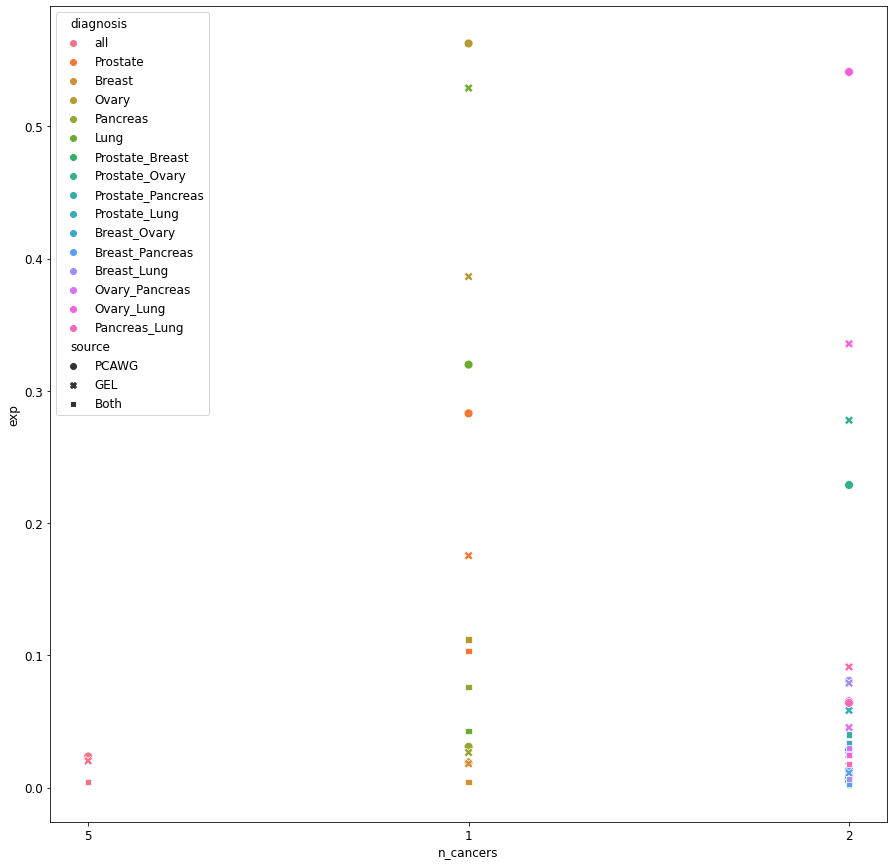

In [17]:
sns.scatterplot(data = result,
                y = 'exp', 
                x ='n_cancers', 
                hue = "diagnosis",
                style = "source",
                s = 80)